In [ ]:
import json
import bz2
import regex
from tqdm import tqdm
from scipy import sparse

In [ ]:
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Задание 1: составить словари для классификации по тональности.
Данные для задания — отзывы
на банки, собранные с нескольких сайтов рунета. Отзывы могут быть как положительными

— оценка 5, так и отрицательными — оценка 1.

In [ ]:
responses = []
with bz2.BZ2File('banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [02:28, 1354.77it/s]


In [ ]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

In [ ]:
df = pd.json_normalize(responses)[['city', 'bank_name', 'author', 'datetime', 'rating_grade', 'title', 'text', 'bank_license', 'num_comments', 'rating_not_checked']]

In [ ]:
df.head()

,city,bank_name,author,datetime,rating_grade,title,text,bank_license,num_comments,rating_not_checked
0,г. Москва,Бинбанк,uhnov1,2015-06-08 12:50:54,NaN,Жалоба,Добрый день! Я не являюсь клиентом банка и пор...,лицензия № 2562,0,False
1,г. Новосибирск,Сбербанк России,Foryou,2015-06-08 11:09:57,NaN,Не могу пользоваться услугой Сбербанк он-лайн,Доброго дня! Являюсь держателем зарплатной кар...,лицензия № 1481,0,False
2,г. Москва,Бинбанк,Vladimir84,2015-06-05 20:14:28,NaN,Двойное списание за один товар.,Здравствуйте! Дублирую свое заявление от 03.0...,лицензия № 2562,1,False
3,г. Ставрополь,Сбербанк России,643609,2015-06-05 13:51:01,NaN,Меняют проценты комиссии не предупредив и не ...,Добрый день!! Я открыл расчетный счет в СберБа...,лицензия № 1481,2,False
4,г. Челябинск,ОТП Банк,anfisa-2003,2015-06-05 10:58:12,NaN,Верните денежные средства за страховку,"04.03.2015 г. взяла кредит в вашем банке, заяв...",лицензия № 2766,1,False


1.1.Разбейте всю коллекцию отзывов на предложения. Лемматизируйте все слова.
Обучите по коллекции предложений word2vec

In [ ]:
pip install pymorphy2 pymorphy2-dicts-ru

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 29.0 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13704 sha256=023bc27e1d4cd7986a405d0eb841526a9c6fd5c2e08184c2733f6bec6828d60a
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
import pymorphy2

In [ ]:
from collections import Counter
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import WordNetLemmatizer
from string import punctuation

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
stop_words = set(stopwords.words('russian'))
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocess_text(text):
    text = re.sub(r'\S*https?:\S*', '', text)
    text = re.sub(r'[^a-zA-Zа-яА-Я]', ' ', text)
    text = text.lower()
    text = text.translate(str.maketrans('', '', punctuation))
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return ' '.join(tokens)

In [ ]:
df['processed_text'] = df['text'][:20000].apply(preprocess_text)

In [ ]:
df = df[df['processed_text'].apply(lambda x: isinstance(x, str))]

In [ ]:
texts = df['processed_text'].tolist()

In [ ]:
sentences = [sent_tokenize(text) for text in texts]

In [ ]:
morph = pymorphy2.MorphAnalyzer()

In [ ]:
def lemmatize(text):
    words = word_tokenize(text)
    lemmas = [morph.parse(word)[0].normal_form for word in words]
    return lemmas

In [ ]:
lemmatized_sentences = [[lemmatize(sentence) for sentence in text] for text in sentences]

In [ ]:
from gensim.models import Word2Vec

In [ ]:
flat_sentences = [sentence for text in lemmatized_sentences for sentence in text]

In [ ]:
model = Word2Vec(sentences=flat_sentences)

1.2.Приведите несколько удачных и неудачных примеров решения стандартных
текстов для word2vec:

тест на определение ближайших слов
тест на аналогии (мужчина — король : женщина — королева)
тест на определение лишнего слова

In [ ]:
model.wv.most_similar('деньга')

[('денежка', 0.6780217289924622),
 ('обратно', 0.6681987047195435),
 ('дс', 0.6143943667411804),
 ('наличка', 0.5961489677429199),
 ('средство', 0.5910510420799255),
 ('наличность', 0.5493887662887573),
 ('благополучно', 0.5108023285865784),
 ('ошибочно', 0.47298067808151245),
 ('наличный', 0.4689817428588867),
 ('кровный', 0.4429622292518616)]

In [ ]:
model.wv.most_similar(positive=['женщина', 'клиент'], negative=['мужчина'])

[('вкладчик', 0.6195392608642578),
 ('считать', 0.5207739472389221),
 ('репутация', 0.5104231238365173),
 ('многий', 0.5094162821769714),
 ('заёмщик', 0.49937909841537476),
 ('абсолютно', 0.4948076605796814),
 ('доверять', 0.4946754276752472),
 ('наплевательский', 0.4783172905445099),
 ('дорожить', 0.4734049141407013),
 ('клиентка', 0.46817052364349365)]

In [ ]:
model.wv.doesnt_match("клиент банк вклад кредит столица".split())

'столица'

1.3.Постройте несколько визуализаций:
TSNE для топ-100 или топ-500 слов и найдите осмысленные кластеры слов
задайте координаты для нового пространства следующим образом: одна ось описывает отношение «плохо — хорошо», вторая — «медленно — быстро», и найдите координаты названий банков в этих координатах

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
words = list(model.wv.index_to_key)[:100]
vectors = model.wv[words]

In [ ]:
tsne = TSNE(n_components=2)
vectors_tsne = tsne.fit_transform(vectors)

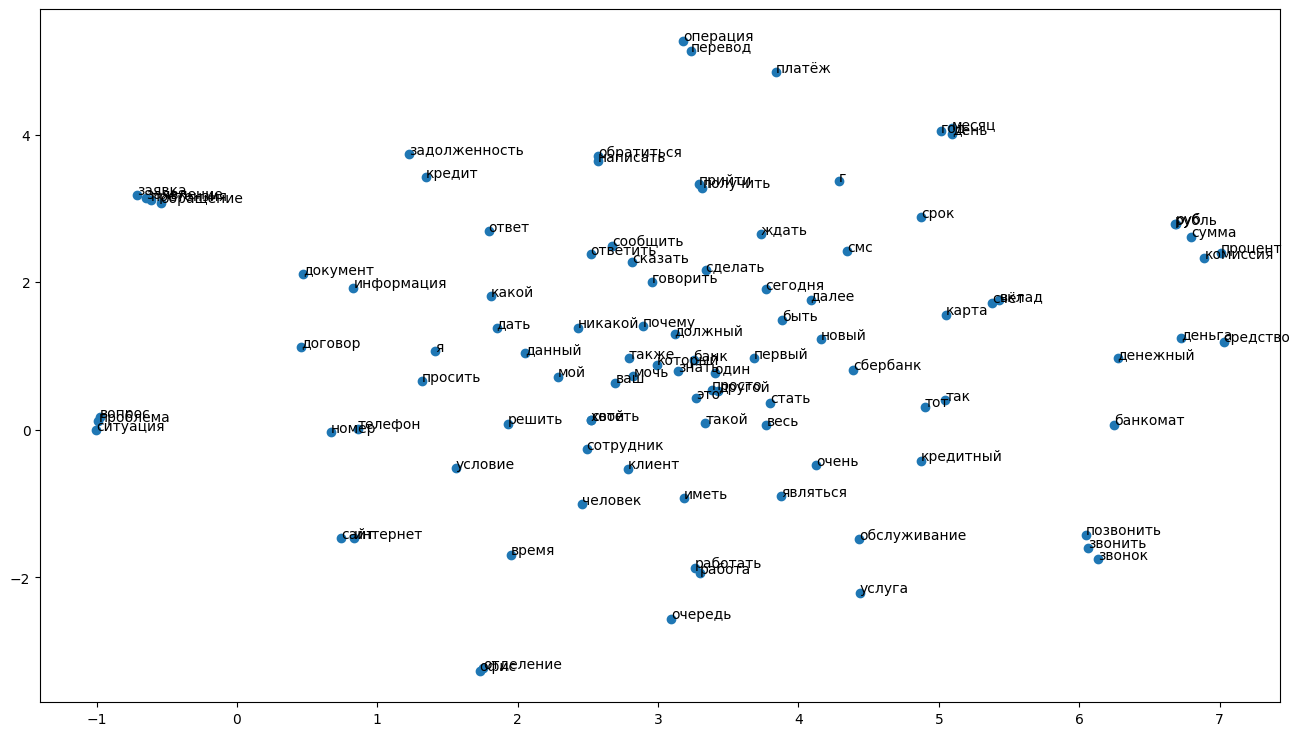

In [ ]:
plt.figure(figsize=(16, 9))
plt.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])

for i, word in enumerate(words):
    plt.annotate(word, xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]))

plt.show()

Мы видим несколько осмысленных кластеров, например "позвонить, звонить, звонок" и "вопрос, проблема, ситуация".

In [ ]:
def get_vector(word):
    return model.wv[word] if word in model.wv else np.zeros(model.vector_size)

In [ ]:
axis_good_bad = get_vector('хороший') - get_vector('плохой')
axis_fast_slow = get_vector('быстрый') - get_vector('медленный')

In [ ]:
bank_coords = np.array([np.dot(get_vector('сбербанк'), axis_good_bad),
                        np.dot(get_vector('сбербанк'), axis_fast_slow)])

In [ ]:
bank_coords

array([10.1478615,  4.655506 ], dtype=float32)

Задание 2: распространить метку.

2.1.Определите 5–8 позитивных слов (например, быстрый, удобный) и 5–8 негативных слов (например, очередь, медленно). Эти слова будут основной будущего оценочного словаря.

In [ ]:
positive_words = ['быстрый', 'удобный', 'хороший', 'отличный', 'прекрасный']
negative_words = ['очередь', 'медленно', 'плохо', 'ужасный', 'неудобный']

2.2.Пусть позитивному классу соответствует метка 1, негативному — -1
Пометьте выбранные слова в лексическом графе соответствующими метками

In [ ]:
import networkx as nx

In [ ]:
G = nx.Graph()

In [ ]:
for word in model.wv.index_to_key:
    G.add_node(word)

In [ ]:
for word1 in model.wv.index_to_key:
    for word2 in model.wv.most_similar(word1, topn=10):
        G.add_edge(word1, word2[0])

In [ ]:
for word in positive_words:
    G.nodes[word]['label'] = 1
for word in negative_words:
    G.nodes[word]['label'] = -1

2.3.Запустите любой известный вам метод распространения метки (Label Propogation) в лексическом графе
На выходе метода распространения ошибки должны быть новые слова, помеченные метками 1 и -1 — это и есть искомые оценочные слова

In [ ]:
from sklearn.semi_supervised import LabelPropagation

In [ ]:
nodes = list(G.nodes)
labels = np.array([G.nodes[node].get('label', 0) for node in nodes])

In [ ]:
label_prop_model = LabelPropagation()

In [ ]:
label_prop_model.fit(model.wv[nodes], labels)

LabelPropagation()

In [ ]:
new_labels = label_prop_model.transduction_

In [ ]:
labeled_words = {nodes[i]: new_labels[i] for i in range(len(nodes)) if new_labels[i] != 0}

In [ ]:
positive_labeled_words = [word for word, label in labeled_words.items() if label == 1]
negative_labeled_words = [word for word, label in labeled_words.items() if label == -1]

In [ ]:
positive_labeled_words

['хороший', 'удобный', 'быстрый', 'отличный', 'прекрасный']